In [77]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


In [78]:
from typing import Mapping

from bbtoolkit.dynamics.callbacks import BaseCallback


class HDCallback(BaseCallback):
    def __init__(
        self,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = None
        self.mode = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):

        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'tc_gen',  # Transformation circuit generator for HD activity.
            'movement_params',  # Movement parameters including position and direction.
            'mental_movement_params',  # Mental movement parameters for cognitive navigation.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates'  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        if self.mode != self.dynamics_params['mode']:
            if self.dynamics_params['mode'] not in self.no_cue_reset_modes:
                self.total_steps = self.init_timesteps

            self.mode = self.dynamics_params['mode']

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        match self.dynamics_params['mode']:
            case 'bottom-up':
                params = self.movement_params
                target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
                position = self.movement_params.position
                direction = self.movement_params.direction
            case 'top-down':
                params = self.mental_movement_params
                target = self.mental_movement_params.move_target if self.mental_movement_params.move_target is not None else self.mental_movement_params.rotate_target
                position = self.mental_movement_params.position
                direction = self.mental_movement_params.direction
            case 'recall':
                params, target, position, direction = None, None, None, None

        if target is not None:
            angle_to_target = math.atan2(
                target[1] - position[1],
                target[0] - position[0]
            ) % (2*np.pi)

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            if diff < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif diff > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.k_ratio.hd = -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

        if self.dynamics_params['mode'] in ('recall', 'top-down'):
            self.k_ratio.hd += self.connectivity.opr.to.hd['phi'] * self.weights.opr.to.hd@self.rates.opr

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        if self.total_steps == 0 and self.dynamics_params['mode'] != 'recall':
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            params.direction = hd_estim

In [79]:
from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()

In [80]:
class PolarCirclePlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['main_ax'] = cache.fig.add_subplot(cache.gc[:6, :], projection='polar')
        self.requires = [
            'main_ax',
            'movement_params',
            'fig'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.rotate_target is not None:
            self.main_ax.plot(
                [
                    self.movement_params.rotate_target,
                    self.movement_params.rotate_target
                ],
                [0, 1],
                marker='o'
            )
        if self.movement_params.direction is not None:
            self.main_ax.plot(
                [
                    self.movement_params.direction,
                    self.movement_params.direction
                ],
                [0, 1],
                marker='o',
                color='red'
            )

    def on_clean(self):
        self.main_ax.clear()

In [81]:

class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

In [82]:
from bbtoolkit.environment import Environment
from bbtoolkit.models.bb.neural_generators import TCGenerator
from bbtoolkit.utils.datautils.configparser import EvalConfigParser


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
env = Environment.load('../data/envs/inserted_wall_environment.pkl')
# env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

In [83]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup


weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
n_hd_neurons = len(weights.hd.to.hd)

activity = TensorGroup(
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
)

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)
weights = weights.operation_with(
    connectivity,
    lambda a, b: a - b.get('inhibitory_phi', 0),
    on_missing_weights='ignore',
    on_missing_sources='ignore'
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
)

In [84]:
plt.plot(weights.hd.to.hd[weights.hd.to.hd.shape[0]//2])
plt.vlines(50, 0, 1)

In [85]:
import bbtoolkit.utils.math
from dataclasses import dataclass

from bbtoolkit.structures.attractors import SelfAttractor

@dataclass
class HDAttractorsContainer:
    hd_attractor: SelfAttractor
    cw_rotation: SelfAttractor
    ccw_rotation: SelfAttractor


class HDCallback(BaseCallback):
    def __init__(
        self,
        hd_attractor: SelfAttractor,
        cw_rot_attractor: SelfAttractor,
        ccw_rot_attractor: SelfAttractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = init_timesteps

        self.hd_attractor = hd_attractor
        self.cw_rot_attractor = cw_rot_attractor
        self.ccw_rot_attractor = ccw_rot_attractor
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
            'hd_attractors',
            'dead_neurons'
        ]

        cache['hd_cue'] = np.zeros(len(self.hd_attractor.kernel))
        cache['hd_attractors'] = HDAttractorsContainer(
            self.hd_attractor,
            self.cw_rot_attractor,
            self.ccw_rot_attractor
        )
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):
        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*bbtoolkit.utils.math.circular_gaussian(self.movement_params.direction, len(self.rates.hd))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rotation = 0

        target = self.movement_params.rotate_target
        direction = self.movement_params.direction

        if self.dead_neurons.indices is not None and self.dead_neurons.indices.size:
            self.rates.hd[self.dead_neurons.indices] = 0

        if target is not None:
            angle_to_target = target

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            def angular_difference(angle1, angle2):
                diff = abs(angle1 - angle2)
                return min(diff, 2 * np.pi - diff)

            if self.hd_estim is not None and diff is not None:
                diff_assumed = angular_difference(angle_to_target, direction)
                diff_estimated = angular_difference(angle_to_target, self.hd_estim)
                if diff_assumed < diff_estimated:
                    # head direction is closer to the target than estimation
                    ...
                else:
                    diff = -diff
                # diff = -diff

            if np.isclose(diff, 0, atol=0.05):
                rotation = 0
            elif diff < 0:
                rotation = (self.cw_rot_attractor(self.rates.hd.T)@self.rates.hd.T).T
            elif diff > 0:
                rotation = (self.ccw_rot_attractor(self.rates.hd.T)@self.rates.hd.T).T

        # ring = (self.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T
        ring = (self.hd_attractor(self.rates.hd.T).values()).T
        # ring[self.dead_neurons.indices] = 0
        self.k_ratio.hd = (
            -self.activity.hd
            + (self.connectivity.hd.to.hd['phi']*ring)
            + self.hd_cue[:, np.newaxis]
            + (self.connectivity.rot.to.rot['phi']*rotation)
        )

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        # self.activity.hd[self.dead_neurons.indices] = 0
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))
        # self.rates.hd[self.dead_neurons.indices] = 0

        # HD estimation
        if self.total_steps == 0:
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            self.hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            # self.movement_params.direction = self.hd_estim



2024-06-18 18:56:00 - DEBUG - Loaded backend inline version unknown.


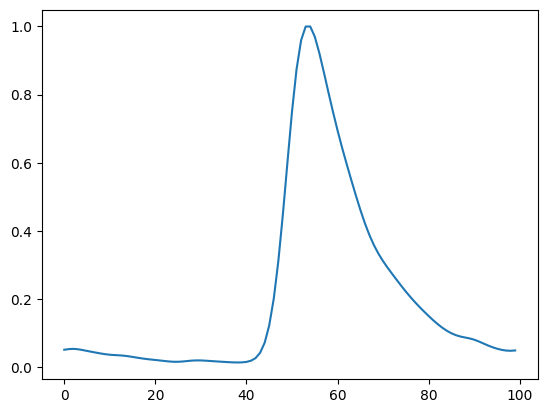

In [185]:
%matplotlib inline
plt.plot(
    weights.rot.to.rot[weights.rot.to.rot.shape[0]//2][::-1]
)

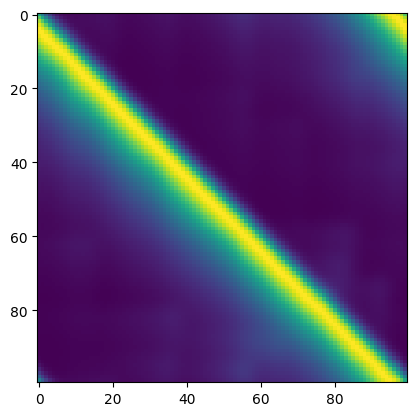

In [186]:
plt.imshow(weights.rot.to.rot)

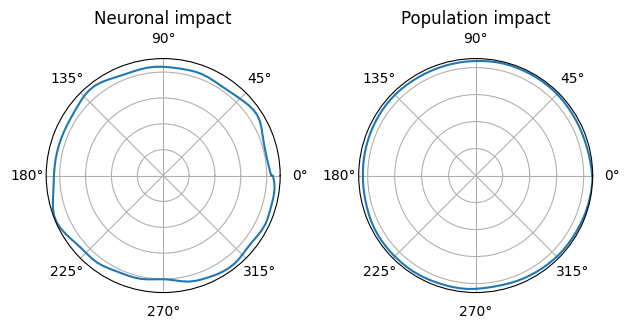

In [188]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar')

ax1.plot(np.linspace(0, 2*np.pi, 100), weights.rot.to.rot.sum(0))
ax1.set_title('Neuronal impact')
ax1.axes.yaxis.set_ticklabels([])
ax2.plot(np.linspace(0, 2*np.pi, 100), weights.rot.to.rot.sum(1))
ax2.set_title('Population impact')
ax2.axes.yaxis.set_ticklabels([])
fig.tight_layout()

In [163]:
class HDPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[6:8, :])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[8:10, :])
        cache['hd_ax_3'] = cache.fig.add_subplot(cache.gc[10:, :])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'hd_ax_3',
            'fig',
            'rates',
            'weights',
            'activity',
            'k_ratio',
            'movement_params',
            'hd_attractors',
            'dead_neurons'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        rot_weights = None
        target = self.movement_params.rotate_target
        direction = self.movement_params.direction
        rotation = np.zeros_like(self.rates.hd)

        if target is not None:
            angle_to_target = target

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            # if np.isclose(diff, 0, atol=0.05):
            #     rotation = np.zeros_like(self.rates.hd)
            # elif diff < 0:
            #     rotation = (self.hd_attractors.cw_rotation(self.rates.hd.T)@self.rates.hd.T).T
            # elif diff > 0:
            #     rotation = (self.hd_attractors.ccw_rotation(self.rates.hd.T)@self.rates.hd.T).T

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.hd_ax_1.plot(self.rates.hd, '-')

        for index in self.dead_neurons.indices:
            self.hd_ax_1.axvline(x=index, color='r', ymin=0, ymax=1)

        self.hd_ax_2.plot((self.hd_attractors.hd_attractor(self.rates.hd.T).values()).T, '-')
        self.hd_ax_3.plot(rotation, '-')

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_1.set_ylim(0, 1)
        self.hd_ax_2.clear()
        self.hd_ax_3.clear()

In [88]:
from typing import Literal, Mapping


class RotationCallback(BaseCallback):
    def __init__(
        self,
        rotation_speed: float
    ):
        super().__init__()
        self.rotation_speed = rotation_speed

    def set_cache(self, cache: Mapping, on_repeat: Literal['raise'] | Literal['ignore'] | Literal['overwrite'] = 'raise'):
        self.requires = [
            'movement_params',
        ]
        super().set_cache(cache, on_repeat)

    def on_step_begin(self, step: int):
        if self.movement_params.direction is not None and\
            self.movement_params.rotate_target is not None:
            if self.movement_params.direction != self.movement_params.rotate_target:
                diff = self.movement_params.rotate_target - self.movement_params.direction
                if diff > np.pi:
                    diff -= 2*np.pi
                elif diff < -np.pi:
                    diff += 2*np.pi

                if np.isclose(diff, 0, atol=0.05):
                    self.movement_params.rotate_target = self.movement_params.direction
                elif diff < 0:
                    self.movement_params.direction -= self.rotation_speed
                elif diff > 0:
                    self.movement_params.direction += self.rotation_speed

                self.movement_params.direction %= 2*np.pi

In [89]:
class RotSpeedPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float], alpha = .5):
        super().__init__()
        self.coords = coords
        self.direction_prev = None
        self.alpha = alpha
        self.ewma_prev = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['rot_ax'] = cache.fig.add_subplot(cache.gc[1, 1])
        self.requires = [
            'rot_ax',
            'dynamics_params',
            'movement_params',
            'activity',
            'hd_attractors',
            'rates'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):

        pop = (self.hd_attractors.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T
        ind = np.where(pop == pop.max())[0][0]

        if self.direction_prev is None:
            diff = 0
        else:
            diff = abs(self.direction_prev - ind)

        self.direction_prev = ind

        instant_rotation_speed = diff/len(self.rates.hd)

        if self.ewma_prev is None:
            self.previous_ewma = instant_rotation_speed
        else:
            self.previous_ewma = (self.alpha * instant_rotation_speed) + ((1 - self.alpha) * self.previous_ewma)


        self.rot_ax.text(
            *self.coords,
            f'Speed: {self.previous_ewma : .2f} s'
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.rot_ax.clear()
        self.rot_ax.set_axis_off()

2024-06-18 18:57:35 - DEBUG - Loaded backend inline version unknown.


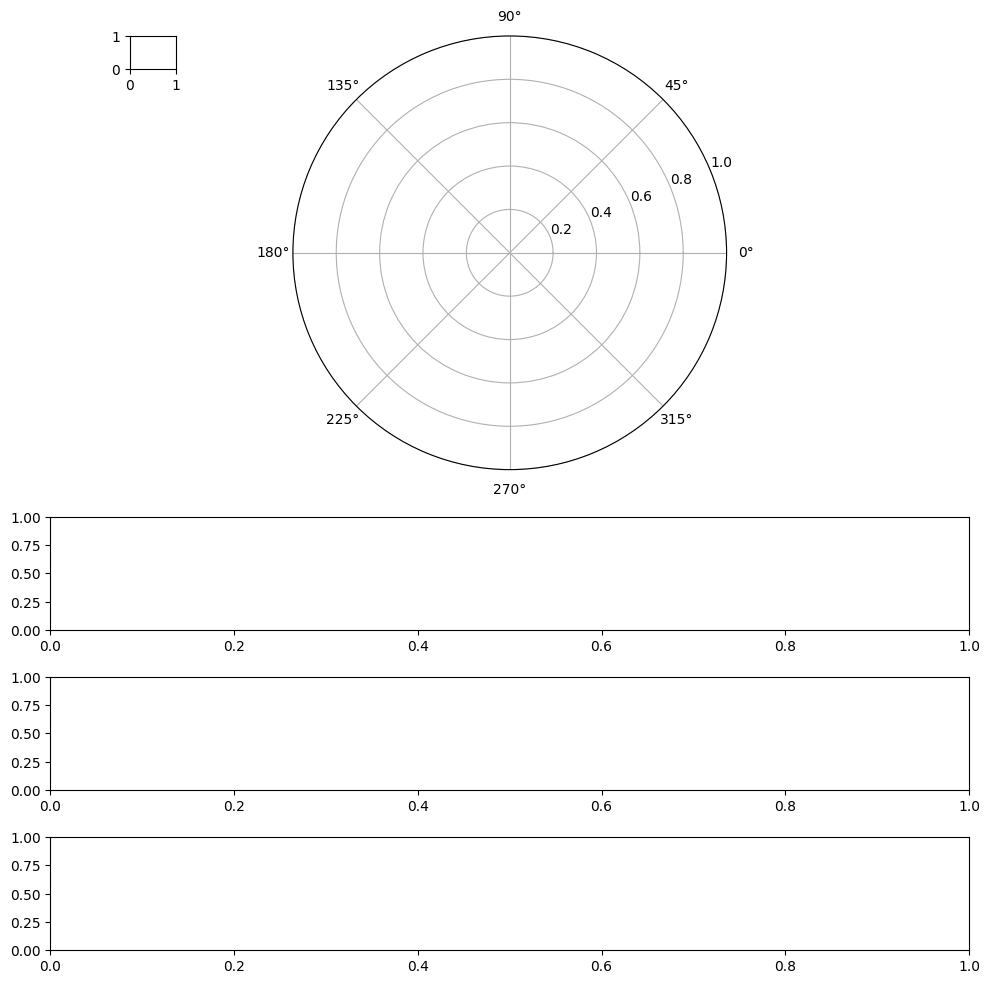

In [189]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d

%matplotlib inline

dt = .005

direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=0)
cache['weights'] = weights.copy()
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
# cache['dead_neurons'] = DotDict(indices=np.random.randint(0, 100, size=40))
cache['dead_neurons'] = DotDict(indices=np.array([]))


dynamics = DynamicsManager(
    dt,
    callbacks=[
        RotationCallback(np.pi/100),
        HDCallback(
            SelfAttractor(gaussian_kernel_1d(n_hd_neurons, .025, amplitude=1) - .4),
            SelfAttractor(gaussian_kernel_1d(n_hd_neurons, .025, .4, 4)),
            SelfAttractor(gaussian_kernel_1d(n_hd_neurons, .025, .6, 4)),
            # Attractor(weights.rot.to.rot[weights.rot.to.rot.shape[0]//2]),
            # Attractor(weights.rot.to.rot[weights.rot.to.rot.shape[0]//2][::-1])
        ),
        TimerCallback(),
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                # RotSpeedPlotter((0, 0), 0.0000001),
                HDPlotter(),
                MouseEventCallback(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        ),
        FramesStoringCallback(5, '../tmp')
    ],
    cache=cache
)


# for _ in dynamics(True):
#     print('out: ', _)

2024-06-18 18:45:05 - DEBUG - Loaded backend inline version unknown.


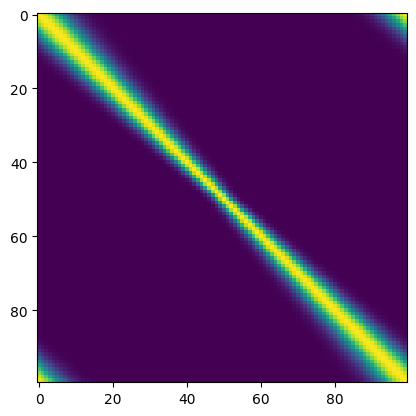

In [179]:
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d
from bbtoolkit.utils.indextools import create_index_matrix, parity_reorder, reorder_doubled_array, shifted_1d

def reorder_batched_array(
    matrix: np.ndarray,
    indices: tuple[np.ndarray]
) -> np.ndarray:
    matrix_reshaped = matrix.reshape(
        matrix.shape[0], *matrix.shape[1:]
    )
    matrix_reshaped[:] = matrix_reshaped[
        :, indices.flatten()
    ]
    return matrix


def tensor2doubled(X):
    _, *shape = X.shape
    return X.reshape(*shape, *shape).transpose(parity_reorder(range(2*len(shape))))


def unbind_shifted_dims(
    tensors: tuple[np.ndarray, ...]
) -> tuple[np.ndarray, ...]:
    out = list()
    for shifted in tensors:
        dim = len(shifted)
        shifted %= dim
        shifted += dim*np.arange(dim)[:, None]
        out.append(shifted)

    return tuple(out)


def doubled2weights(
    tensor: np.ndarray
) -> np.ndarray:
    shape = tuple(dim for i, dim in enumerate(tensor.shape) if i % 2)
    return reorder_doubled_array(
        tensor,
        unbind_shifted_dims(shifted_1d(*(np.arange(i) for i in shape)))
    ).transpose(
        parity_reorder(
            tuple(range(2*len(shape)))
        )
    ).reshape(
        side := np.prod(shape), side
    )


high = .05
low = .017

kernels = [
    gaussian_kernel_1d(n_hd_neurons, sigma, center=.5, amplitude=1) - .4
    for sigma in
    # np.linspace(0.1, 0.01, 50)
    np.append(
        np.linspace(high, low, 50),
        np.linspace(low, high, 50),
    )
]
%matplotlib inline
kernels = np.stack(kernels)
kernels = reorder_batched_array(
    kernels,
    create_index_matrix((100, ))[0]
)
kernels = tensor2doubled(kernels)
weights_hd = doubled2weights(kernels)
plt.imshow(weights_hd)

2024-06-18 18:45:05 - DEBUG - Loaded backend inline version unknown.
2024-06-18 18:45:05 - DEBUG - Loaded backend inline version unknown.


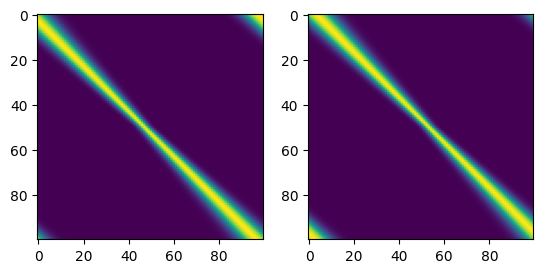

In [180]:
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d

kernels = [
    gaussian_kernel_1d(n_hd_neurons, sigma, .47, 4)
    for sigma in
    # np.linspace(0.1, 0.01, 50)
    np.append(
        np.linspace(high, low, 50),
        np.linspace(low, high, 50),
    )
]
%matplotlib inline
kernels = np.stack(kernels)
kernels = reorder_batched_array(
    kernels,
    create_index_matrix((100, ))[0]
)
kernels = tensor2doubled(kernels)
weights_cw = doubled2weights(kernels)

kernels = [
    gaussian_kernel_1d(n_hd_neurons, sigma, .53, 4)
    for sigma in
    # np.linspace(0.02, 0.01, 100)
    np.append(
        np.linspace(high, low, 50),
        np.linspace(low, high, 50),
    )
]
%matplotlib inline
kernels = np.stack(kernels)
kernels = reorder_batched_array(
    kernels,
    create_index_matrix((100, ))[0]
)
kernels = tensor2doubled(kernels)
weights_ccw = doubled2weights(kernels)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(weights_cw)
ax2.imshow(weights_ccw)

In [181]:
dynamics.callbacks[1].hd_attractor.weights = weights_hd
# dynamics.callbacks[1].cw_rot_attractor.weights = weights_cw
# dynamics.callbacks[1].cw_rot_attractor.weights = weights_ccw

In [182]:
%matplotlib qt
for _ in dynamics(True):
    print('out: ', _)

2024-06-18 18:45:06 - DEBUG - Loaded backend qtagg version 6.7.0.
2024-06-18 18:45:06 - DEBUG - HD CUE INITIATED
2024-06-18 18:45:11 - DEBUG - HD CUE REMOVED


out:  (None, None, None, None, None)


KeyboardInterrupt: 

In [183]:
from bbtoolkit.utils.viz.video import make_video_from_images


image_directory = '../tmp'
video_save_path = '../data/videos/imb_attr(0).mp4'
make_video_from_images(image_directory, video_save_path, 2)

2024-06-18 18:46:02 - INFO - Video saved to ../data/videos/imb_attr(0).mp4


In [184]:
from bbtoolkit.utils.datautils import remove_files_from_dir


remove_files_from_dir('../tmp')

2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_5.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_10.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_15.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_20.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_25.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_30.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_35.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_40.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_45.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_50.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_55.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_60.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_65.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_70.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_75.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_80.png
2024-06-18 18:46:04 - INFO - Removed: ../tmp/frame_85.png
2024-06-18 18:4